## Análisis Exploratorio de Datos (EDA)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("veterinary_clinical_dataset_clean.csv")
df.head()

AnimalName          Breed   Age  Weight_kg    MedicalHistory Symptom_1  \
0        dog     rottweiler   6.0       32.1   chronic illness  anorexia   
1        dog        bulldog   9.9       18.5        vaccinated  lethargy   
2        dog         beagle  13.9       18.9  parasite history      pain   
3        cat  scottish fold   5.8        6.3    recent surgery  vomiting   
4        cat        persian  11.2        4.9    recent surgery    severe   

     Symptom_2             Symptom_3 Symptom_4               Symptom_5  
0  hydrophobia         drooping ears  diarrhea   shyness or aggression  
1     weakness          horny growth     fever                coughing  
2  weight loss           weight loss  sneezing  drop on egg production  
3         pain    edema in lower jaw      pain                weakness  
4  weight loss  egg production stops  weakness     poor body condition

### istribución de variables categóricas principales

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\3376304973.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="AnimalName", data=df, ax=axes[0], palette="Set2")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\3376304973.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_breeds.values, y=top_breeds.index, palette="viridis", ax=axes[1])


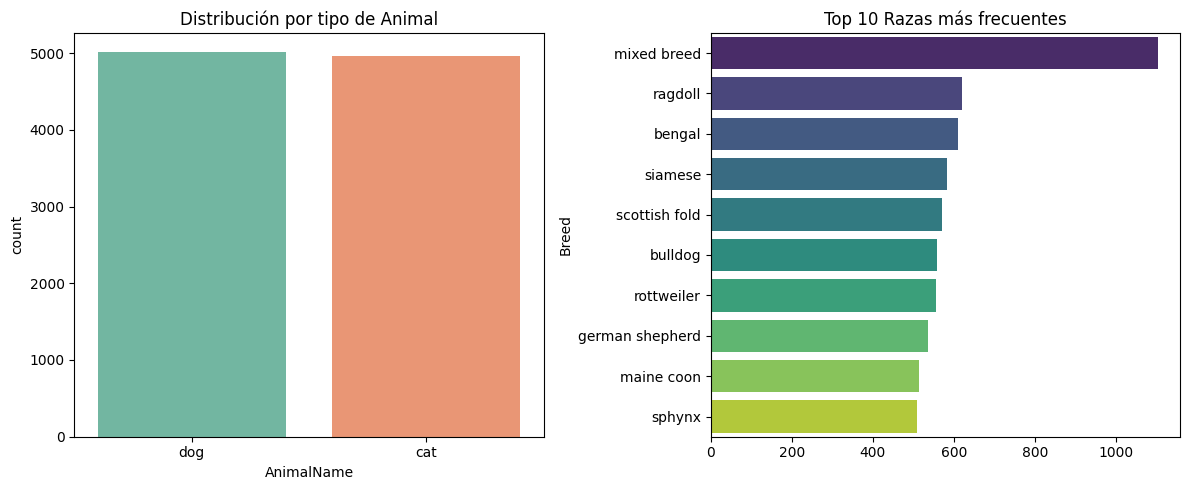

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(x="AnimalName", data=df, ax=axes[0], palette="Set2")
axes[0].set_title("Distribución por tipo de Animal")

top_breeds = df['Breed'].value_counts().head(10)
sns.barplot(x=top_breeds.values, y=top_breeds.index, palette="viridis", ax=axes[1])
axes[1].set_title("Top 10 Razas más frecuentes")
plt.tight_layout()
plt.show()

### Distribución de variables numéricas (Edad y Peso)

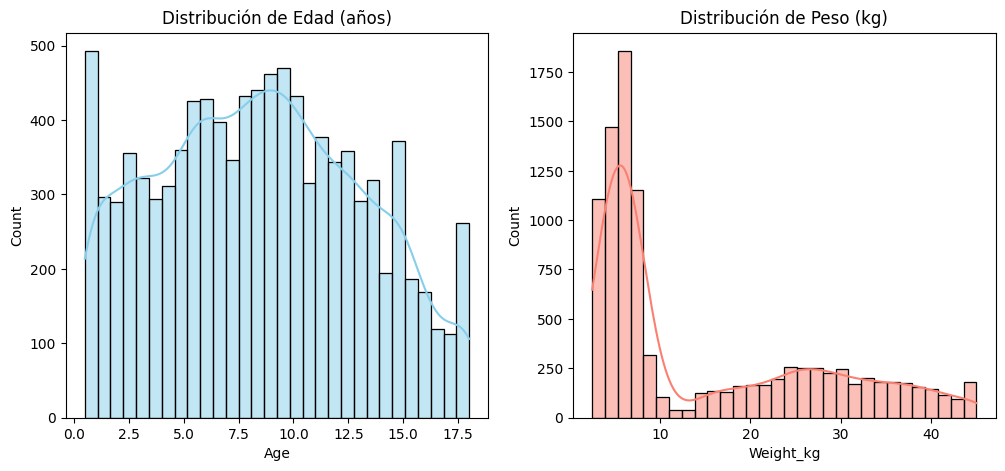

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df['Age'], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribución de Edad (años)")

sns.histplot(df['Weight_kg'], bins=30, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Distribución de Peso (kg)")
plt.show()

### Frecuencia de síntomas reportados

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\2308641043.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=symptom_counts.values, y=symptom_counts.index, palette="magma")


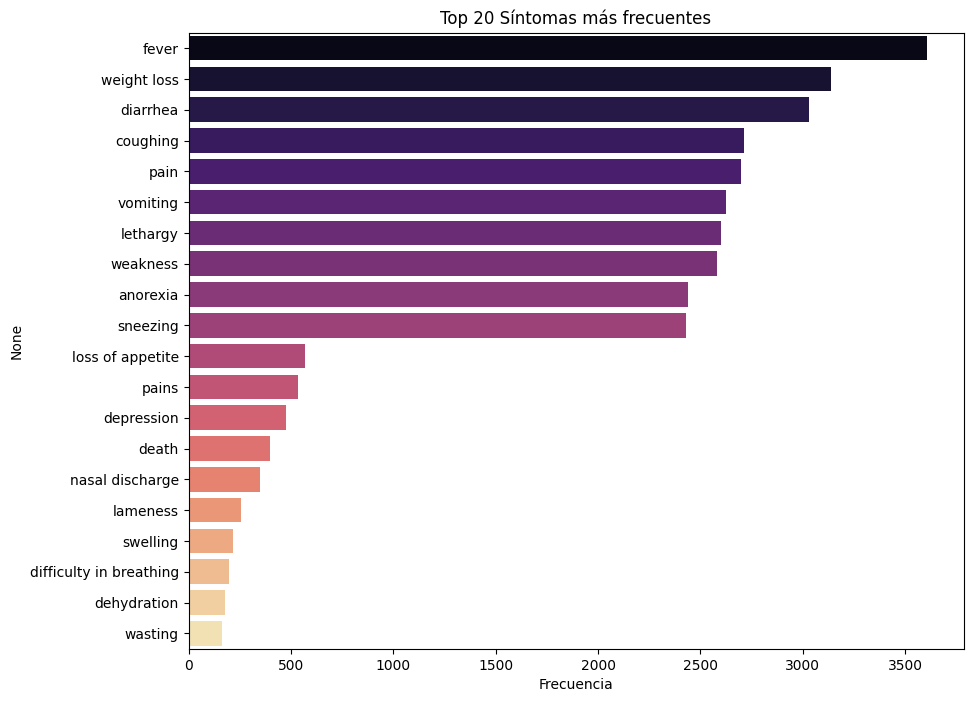

In [13]:
symptom_cols = [col for col in df.columns if "Symptom" in col]
symptoms_series = pd.concat([df[col] for col in symptom_cols]).str.lower().str.strip()
symptom_counts = symptoms_series.value_counts().head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=symptom_counts.values, y=symptom_counts.index, palette="magma")
plt.title("Top 20 Síntomas más frecuentes")
plt.xlabel("Frecuencia")
plt.show()

### Correlación entre variables clínicas (Edad y Peso)

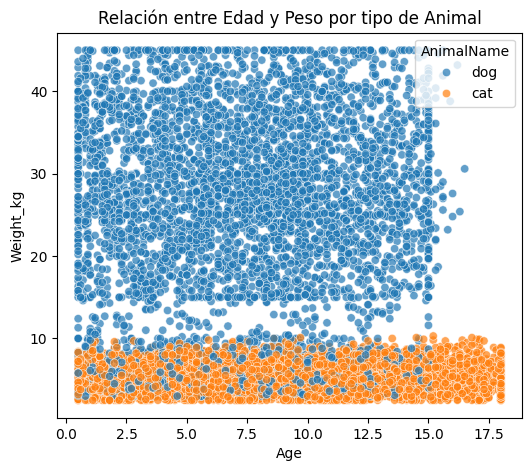

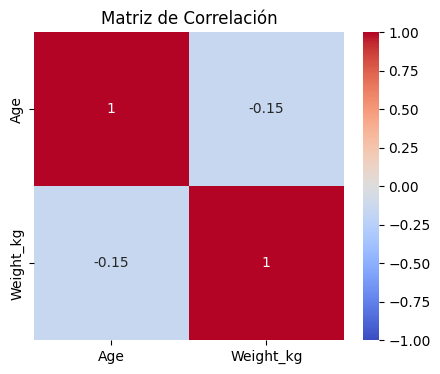

In [14]:
plt.figure(figsize=(6,5))
sns.scatterplot(x="Age", y="Weight_kg", hue="AnimalName", data=df, alpha=0.7)
plt.title("Relación entre Edad y Peso por tipo de Animal")
plt.show()

# Heatmap de correlación numérica
plt.figure(figsize=(5,4))
sns.heatmap(df[["Age", "Weight_kg"]].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

### Correlación entre variables categóricas (AnimalName, Breed, MedicalHistory)


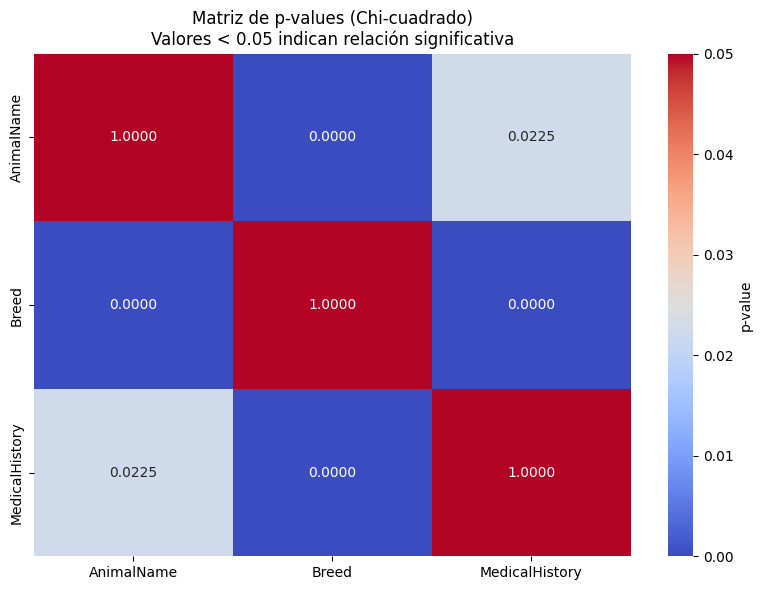

In [26]:
from scipy.stats import chi2_contingency
categorical_vars = ['AnimalName', 'Breed', 'MedicalHistory']

# Crear matriz de p-values para Chi-cuadrado
chi2_results = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 == var2:
            chi2_results.loc[var1, var2] = 1.0
        else:
            contingency_table = pd.crosstab(df[var1], df[var2])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            chi2_results.loc[var1, var2] = p_value

# Convertir a float para visualización
chi2_results = chi2_results.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(chi2_results, annot=True, fmt='.4f', cmap='coolwarm', 
            vmin=0, vmax=0.05, cbar_kws={'label': 'p-value'})
plt.title('Matriz de p-values (Chi-cuadrado)\nValores < 0.05 indican relación significativa')
plt.tight_layout()
plt.show()

## Análisis Exploratorio de Datos de Imágenes (Perros y Gatos)

En esta sección realizamos EDA sobre los datasets de imágenes de gatos y perros. El objetivo es explorar la distribución de clases, tamaños de imágenes y su calidad.

In [27]:
import os, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

base_cat = "cat_skin_disease_split"
base_dog = "dog_skin_disease_split"

def get_image_info(base_dir):
    info = []
    for split in ["train", "valid", "test"]:
        split_path = os.path.join(base_dir, split)
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            for file in os.listdir(cls_path):
                if file.lower().endswith((".jpg",".jpeg",".png")):
                    path = os.path.join(cls_path, file)
                    try:
                        img = Image.open(path)
                        w, h = img.size
                        info.append({
                            'split': split,
                            'class': cls,
                            'width': w,
                            'height': h,
                            'aspect_ratio': w/h,
                            'mode': img.mode,
                            'size_kb': os.path.getsize(path)/1024
                        })
                    except:
                        pass
    return pd.DataFrame(info)

df_cat = get_image_info(base_cat)
df_dog = get_image_info(base_dog)

print("Gatos:", df_cat.shape)
print("Perros:", df_dog.shape)
df_cat.head(10)

Gatos: (999, 7)
Perros: (4178, 7)


split         class  width  height  aspect_ratio mode    size_kb
0  train  Flea_Allergy    640     640      1.000000  RGB  42.935547
1  train  Flea_Allergy    640     640      1.000000  RGB  45.489258
2  train  Flea_Allergy    640     640      1.000000  RGB  60.833008
3  train  Flea_Allergy    640     640      1.000000  RGB  34.354492
4  train  Flea_Allergy    640     640      1.000000  RGB  64.258789
5  train  Flea_Allergy    150     200      0.750000  RGB   0.393555
6  train  Flea_Allergy    150     200      0.750000  RGB   0.409180
7  train  Flea_Allergy    200     120      1.666667  RGB   0.415039
8  train  Flea_Allergy    640     640      1.000000  RGB  67.132812
9  train  Flea_Allergy    620     372      1.666667  RGB  25.345703

### Distribución de imágenes por clase y split

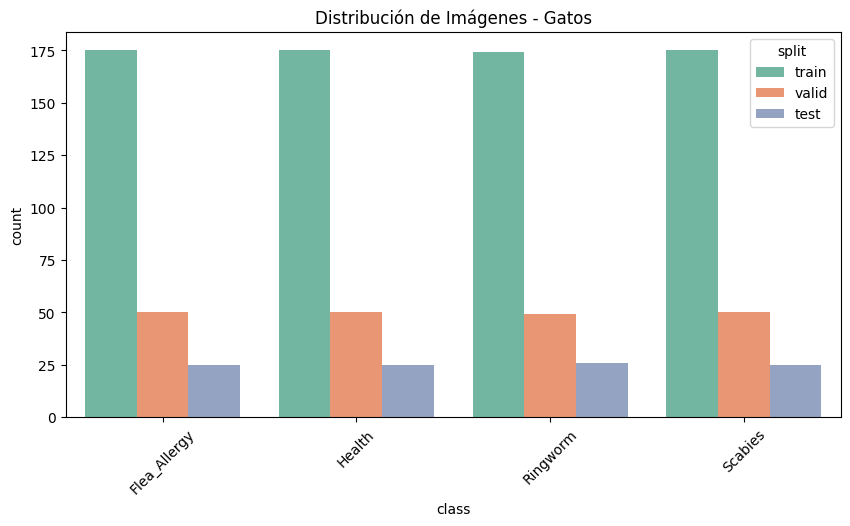

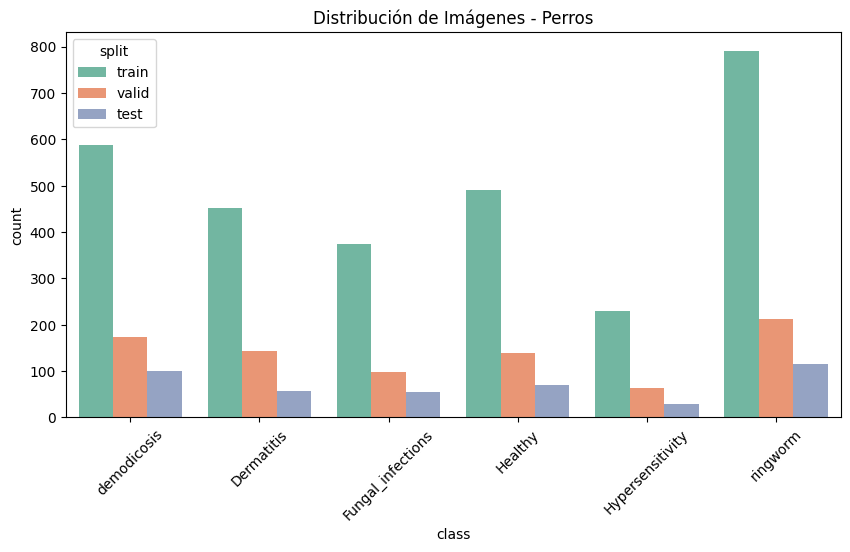

In [16]:
def plot_distribution(df, title):
    plt.figure(figsize=(10,5))
    sns.countplot(x="class", hue="split", data=df, palette="Set2")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_distribution(df_cat, "Distribución de Imágenes - Gatos")
plot_distribution(df_dog, "Distribución de Imágenes - Perros")

### Ejemplos de imágenes por clase

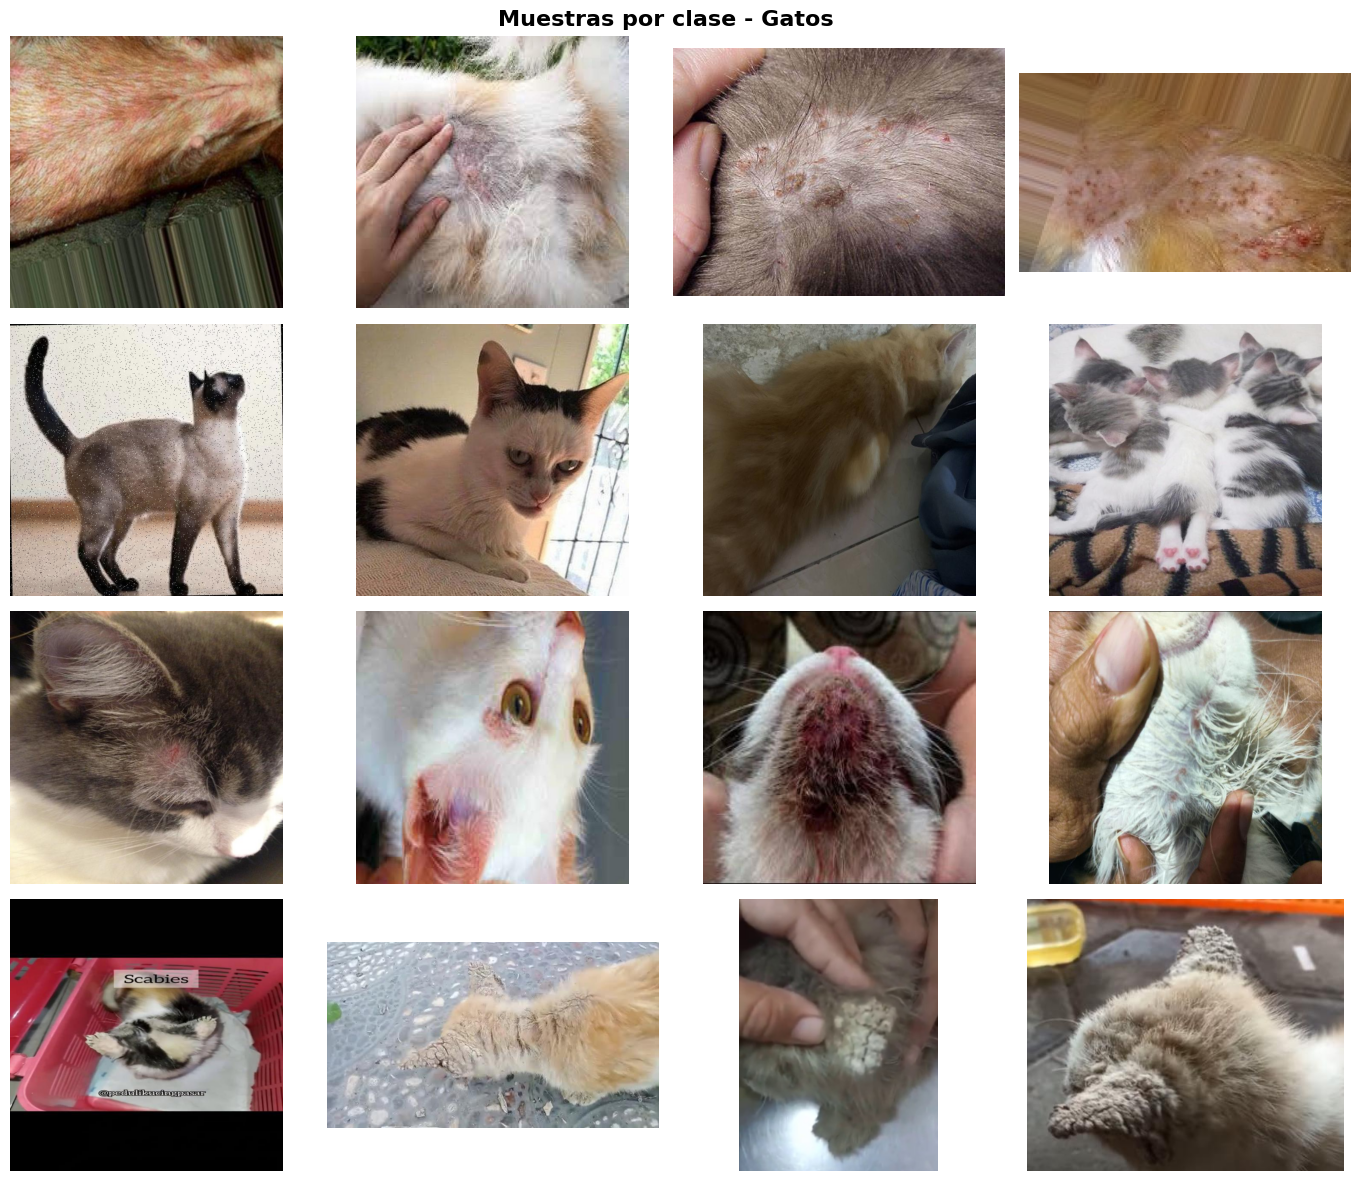

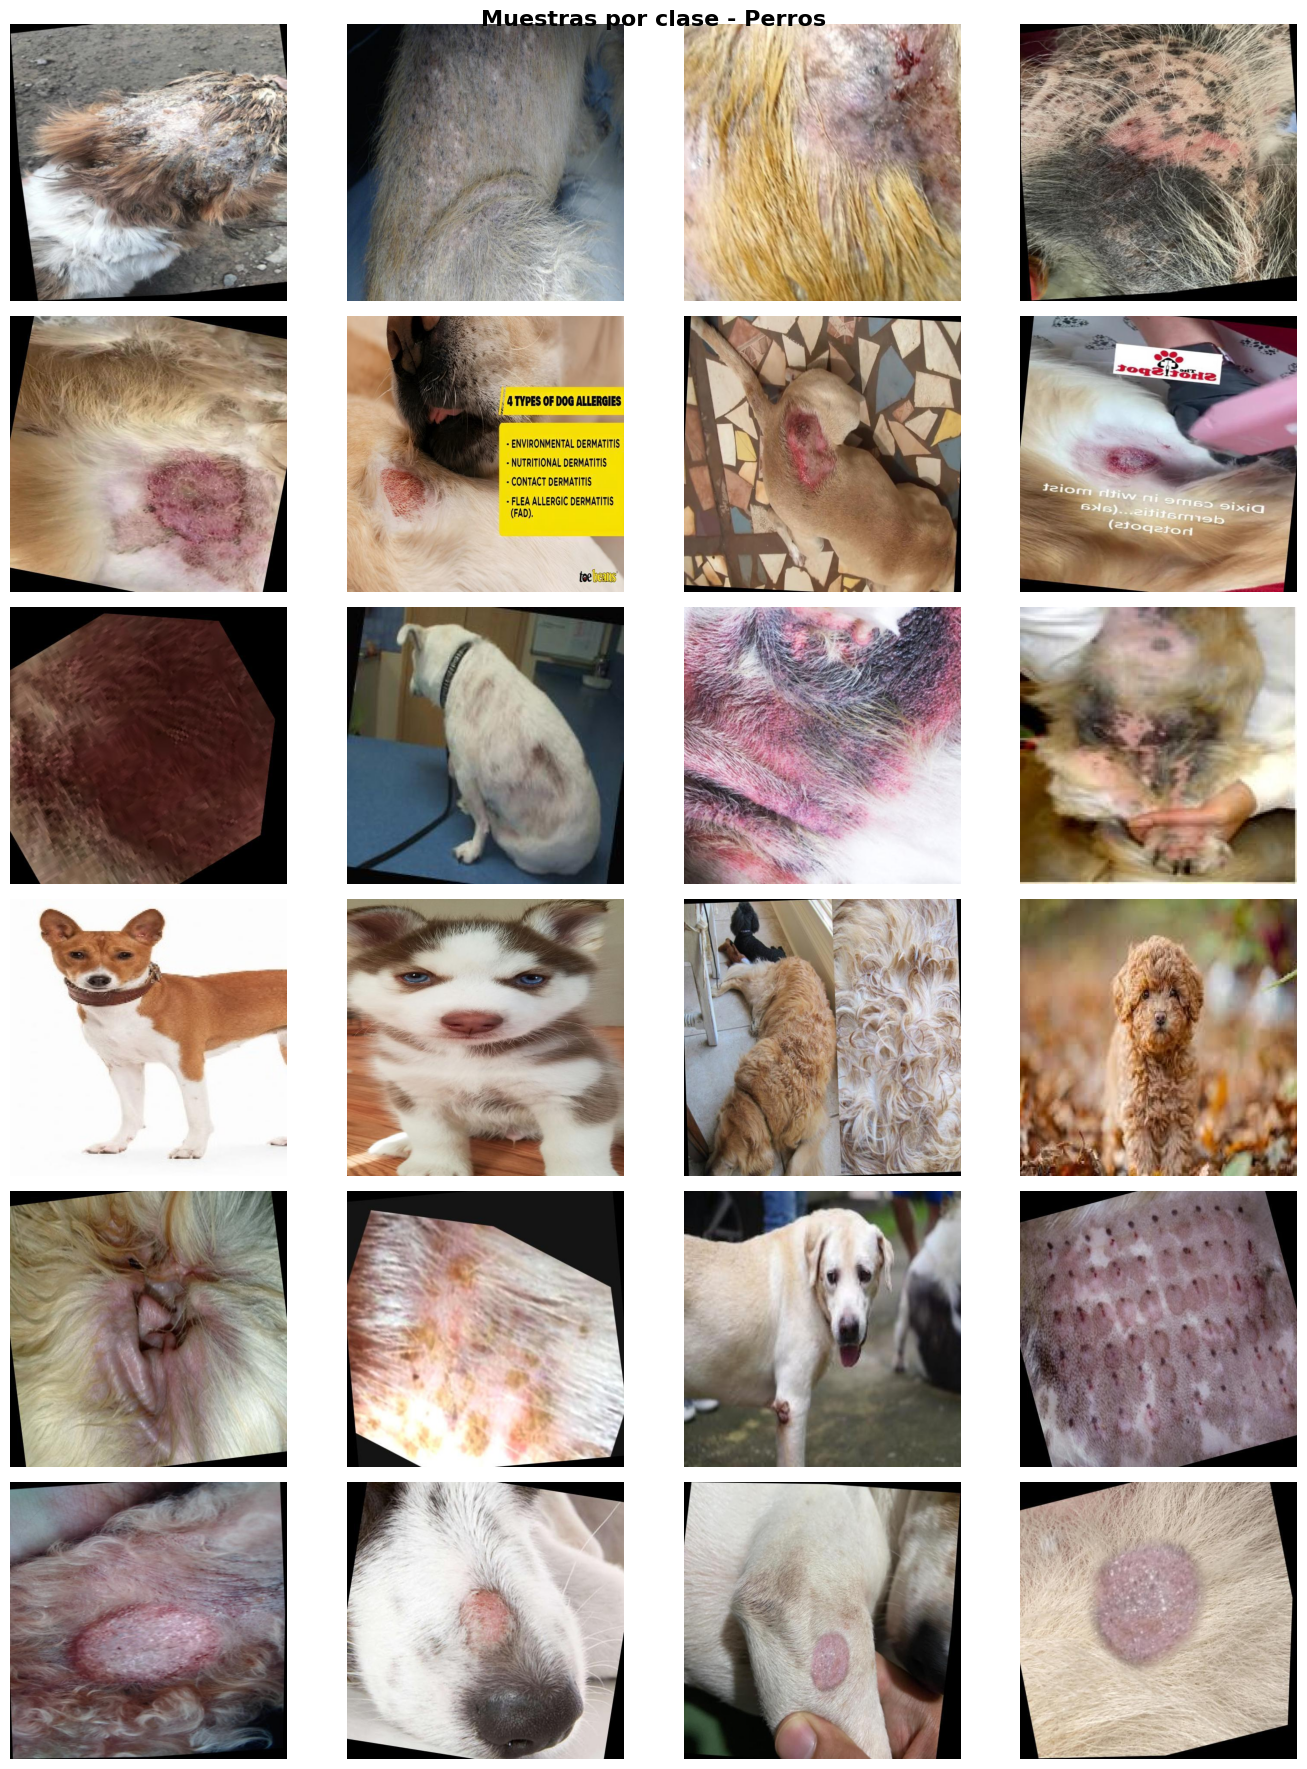

In [17]:
def show_samples(base_dir, classes, title):
    fig, axes = plt.subplots(len(classes), 4, figsize=(14, 3*len(classes)))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    for i, cls in enumerate(classes):
        path = os.path.join(base_dir, 'train', cls)
        files = [f for f in os.listdir(path) if f.lower().endswith((".jpg",".jpeg",".png"))]
        for j in range(4):
            file = random.choice(files)
            img = Image.open(os.path.join(path, file))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j==0:
                axes[i, j].set_ylabel(cls, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_samples(base_cat, df_cat['class'].unique(), "Muestras por clase - Gatos")
show_samples(base_dog, df_dog['class'].unique(), "Muestras por clase - Perros")

### Distribución de dimensiones y aspect ratio

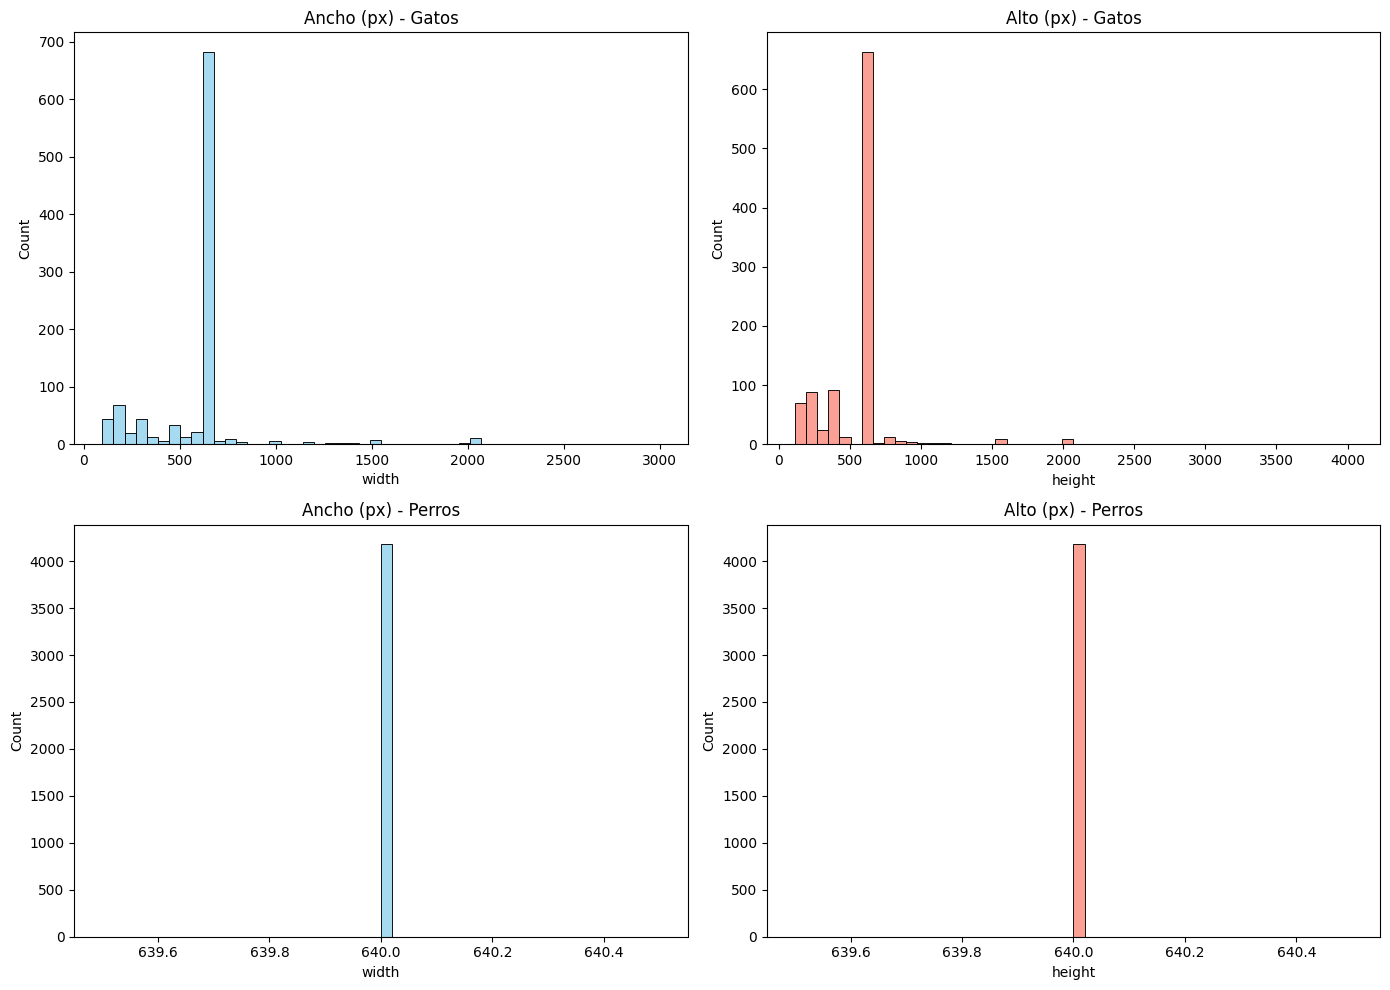

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\418881387.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_cat['aspect_ratio'], label='Gatos', shade=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\418881387.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_dog['aspect_ratio'], label='Perros', shade=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\418881387.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_dog['aspect_ratio'], label='Perros', shade=True)


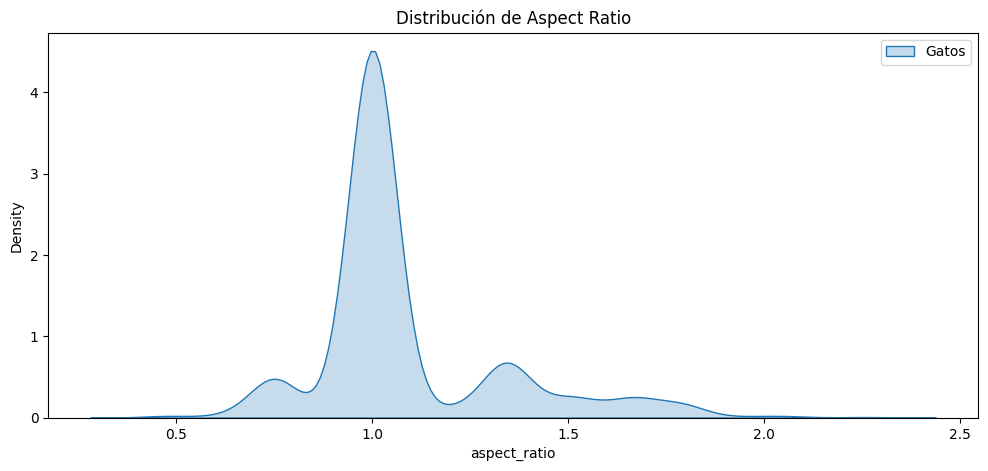

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
sns.histplot(df_cat['width'], bins=50, ax=axes[0,0], color='skyblue')
axes[0,0].set_title("Ancho (px) - Gatos")
sns.histplot(df_cat['height'], bins=50, ax=axes[0,1], color='salmon')
axes[0,1].set_title("Alto (px) - Gatos")

sns.histplot(df_dog['width'], bins=50, ax=axes[1,0], color='skyblue')
axes[1,0].set_title("Ancho (px) - Perros")
sns.histplot(df_dog['height'], bins=50, ax=axes[1,1], color='salmon')
axes[1,1].set_title("Alto (px) - Perros")
plt.tight_layout()
plt.show()

# Aspect ratio
plt.figure(figsize=(12,5))
sns.kdeplot(df_cat['aspect_ratio'], label='Gatos', shade=True)
sns.kdeplot(df_dog['aspect_ratio'], label='Perros', shade=True)
plt.title("Distribución de Aspect Ratio")
plt.legend()
plt.show()

### Distribución de tamaño de archivos

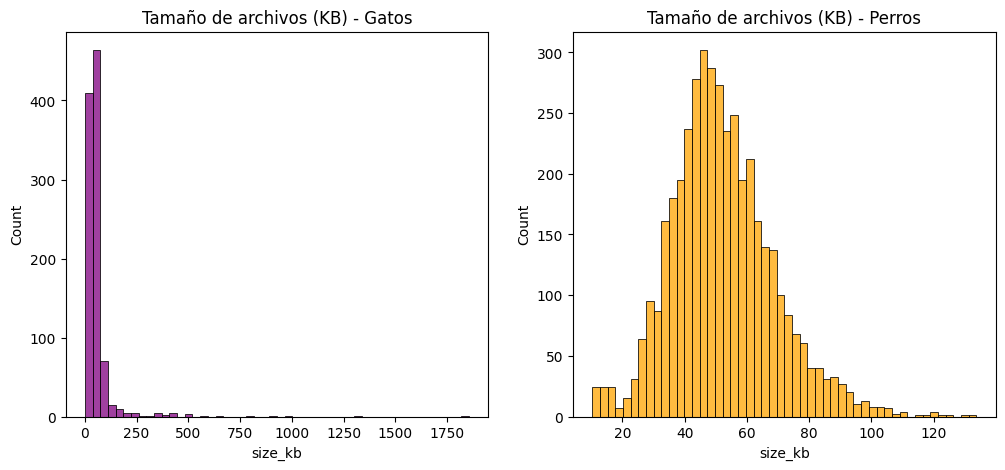

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_cat['size_kb'], bins=50, ax=axes[0], color='purple')
axes[0].set_title("Tamaño de archivos (KB) - Gatos")
sns.histplot(df_dog['size_kb'], bins=50, ax=axes[1], color='orange')
axes[1].set_title("Tamaño de archivos (KB) - Perros")
plt.show()

### Modos de color

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\3010443320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='mode', data=df_cat, ax=axes[0], palette='Set2')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19180\3010443320.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='mode', data=df_dog, ax=axes[1], palette='Set3')


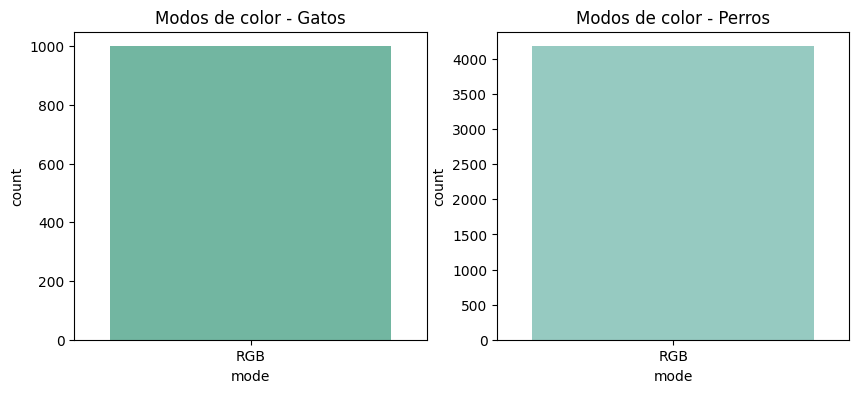

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='mode', data=df_cat, ax=axes[0], palette='Set2')
axes[0].set_title("Modos de color - Gatos")
sns.countplot(x='mode', data=df_dog, ax=axes[1], palette='Set3')
axes[1].set_title("Modos de color - Perros")
plt.show()